In [13]:
import os
import numpy as np
import ROOT

In [14]:
ERA = "2018"
CHANNEL = "Skim1E2Mu"
histkey = "pair/mass"

WORKDIR = "/home/choij/workspace/ChargedHiggsAnalysisV2"

DATASTREAM = ""
if CHANNEL == "Skim1E2Mu": DATASTREAM = "MuonEG"
if CHANNEL == "Skim3Mu": DATASTREAM = "DoubleMuon"

LumiInfo = {    # /fb
        "2016preVFP": 19.5,
        "2016postVFP": 16.8,
        "2017": 41.5,
        "2018": 59.8
}

In [15]:
## helper functions
def setInfoTo(text: ROOT.TLatex):
    text.SetTextSize(0.035)
    text.SetTextFont(42)

def setLogoTo(text: ROOT.TLatex):
    text.SetTextSize(0.04)
    text.SetTextFont(61)
    
def setWorkInProgressTo(text: ROOT.TLatex):
    text.SetTextSize(0.035)
    text.SetTextFont(52)
    
def setExtraInfoTo(text: ROOT.TLatex):
    text.SetTextSize(0.05)
    text.SetTextFont(42)

In [16]:
# Load histograms from MatrixEstimator
file_path = f"{WORKDIR}/SKFlatOutput/MatrixEstimator/{ERA}/{CHANNEL}__RunSyst__/DATA/MatrixEstimator_{DATASTREAM}.root" 
assert os.path.exists(file_path)
f = ROOT.TFile.Open(file_path)

h_Central = f.Get(f"{CHANNEL.replace('Skim', 'SR')}/Central/{histkey}"); h_Central.SetDirectory(0); h_Central.SetStats(0); h_Central.Rebin(5)
h_PromptNormUp = f.Get(f"{CHANNEL.replace('Skim', 'SR')}/PromptNormUp/{histkey}"); h_PromptNormUp.SetDirectory(0); h_PromptNormUp.SetStats(0); h_PromptNormUp.Rebin(5)
h_PromptNormDown = f.Get(f"{CHANNEL.replace('Skim', 'SR')}/PromptNormDown/{histkey}"); h_PromptNormDown.SetDirectory(0); h_PromptNormDown.SetStats(0); h_PromptNormDown.Rebin(5)
h_MotherJetPtUp = f.Get(f"{CHANNEL.replace('Skim', 'SR')}/MotherJetPtUp/{histkey}"); h_MotherJetPtUp.SetDirectory(0); h_MotherJetPtUp.SetStats(0); h_MotherJetPtUp.Rebin(5) 
h_MotherJetPtDown = f.Get(f"{CHANNEL.replace('Skim', 'SR')}/MotherJetPtDown/{histkey}"); h_MotherJetPtDown.SetDirectory(0); h_MotherJetPtDown.SetStats(0); h_MotherJetPtDown.Rebin(5)
h_RequireHeavyTag = f.Get(f"{CHANNEL.replace('Skim', 'SR')}/RequireHeavyTag/{histkey}"); h_RequireHeavyTag.SetDirectory(0); h_RequireHeavyTag.SetStats(0); h_RequireHeavyTag.Rebin(5) 
f.Close()

In [17]:
nBins = h_Central.GetNbinsX()
systUp = np.zeros(nBins)
systDown = np.zeros(nBins)
x = np.zeros(nBins)
y = np.zeros(nBins)
ex = np.zeros(nBins)

In [18]:
for i in range(1, nBins+1):
    central = h_Central.GetBinContent(i)
    
    dPromptNormUp = h_PromptNormUp.GetBinContent(i) - central
    dPromptNormDown = h_PromptNormDown.GetBinContent(i) - central
    dMotherJetPtUp = h_MotherJetPtUp.GetBinContent(i) - central
    dMotherJetPtDown = h_MotherJetPtDown.GetBinContent(i) - central
    dRequireHeavyTag = h_RequireHeavyTag.GetBinContent(i) - central
    
    # Choose Up and Down variation
    prompt_pos = 0.
    prompt_neg = 0.
    if dPromptNormUp > 0. and dPromptNormDown > 0.:
        prompt_pos = max(dPromptNormUp, dPromptNormDown)
        prompt_neg = 0.
    elif dPromptNormUp > 0. and dPromptNormDown < 0.:
        prompt_pos, prompt_neg = dPromptNormUp, dPromptNormDown
    elif dPromptNormUp < 0. and dPromptNormDown > 0.:
        prompt_pos, prompt_neg = dPromptNormDown, dPromptNormUp
    else: # both negative
        prompt_pos = 0.
        prompt_neg = min(dPromptNormUp, dPromptNormDown)
        
    jetpt_pos = 0.
    jetpt_neg = 0.
    if dMotherJetPtUp > 0. and dMotherJetPtDown > 0.:
        jetpt_pos = max(dMotherJetPtUp, dMotherJetPtDown)
        jetpt_neg = 0.
    elif dMotherJetPtUp > 0. and dMotherJetPtDown < 0.:
        jetpt_pos, jetpt_neg = dMotherJetPtUp, dMotherJetPtDown
    elif dMotherJetPtDown < 0. and dMotherJetPtDown > 0.:
        jetpt_pog, jetpt_neg = dMotherJetPtDown, dMotherJetPtUp
    else:
        jetpt_pos = 0.
        jetpt_neg = min(dMotherJetPtUp, dMotherJetPtDown)
    
    systUp[i-1] = np.sqrt(
        prompt_pos**2 + jetpt_pos**2 + (dRequireHeavyTag if dRequireHeavyTag > 0 else 0)**2 
    )
    systDown[i-1] = np.sqrt(
        prompt_neg**2 + jetpt_neg**2 + (dRequireHeavyTag if dRequireHeavyTag < 0 else 0)**2 
    )
    
    # Prepare for TGraphAsymmErrors
    x[i-1] = h_Central.GetBinCenter(i)
    y[i-1] = central

In [19]:
# Combine with statistical errors
totalUp = np.zeros(nBins)
totalDown = np.zeros(nBins)
for i in range(1, nBins+1):
    stat = h_Central.GetBinError(i)
    totalUp[i-1] = np.sqrt(stat**2 + systUp[i-1]**2)
    totalDown[i-1] = np.sqrt(stat**2 + systDown[i-1]**2)

In [20]:
g = ROOT.TGraphAsymmErrors(nBins, x, y, ex, ex, systDown, systUp)
h_error = h_Central.Clone("error, 25%")
for i in range(1, h_error.GetNbinsX()+1):
    h_error.SetBinError(i, h_Central.GetBinContent(i)*0.2)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


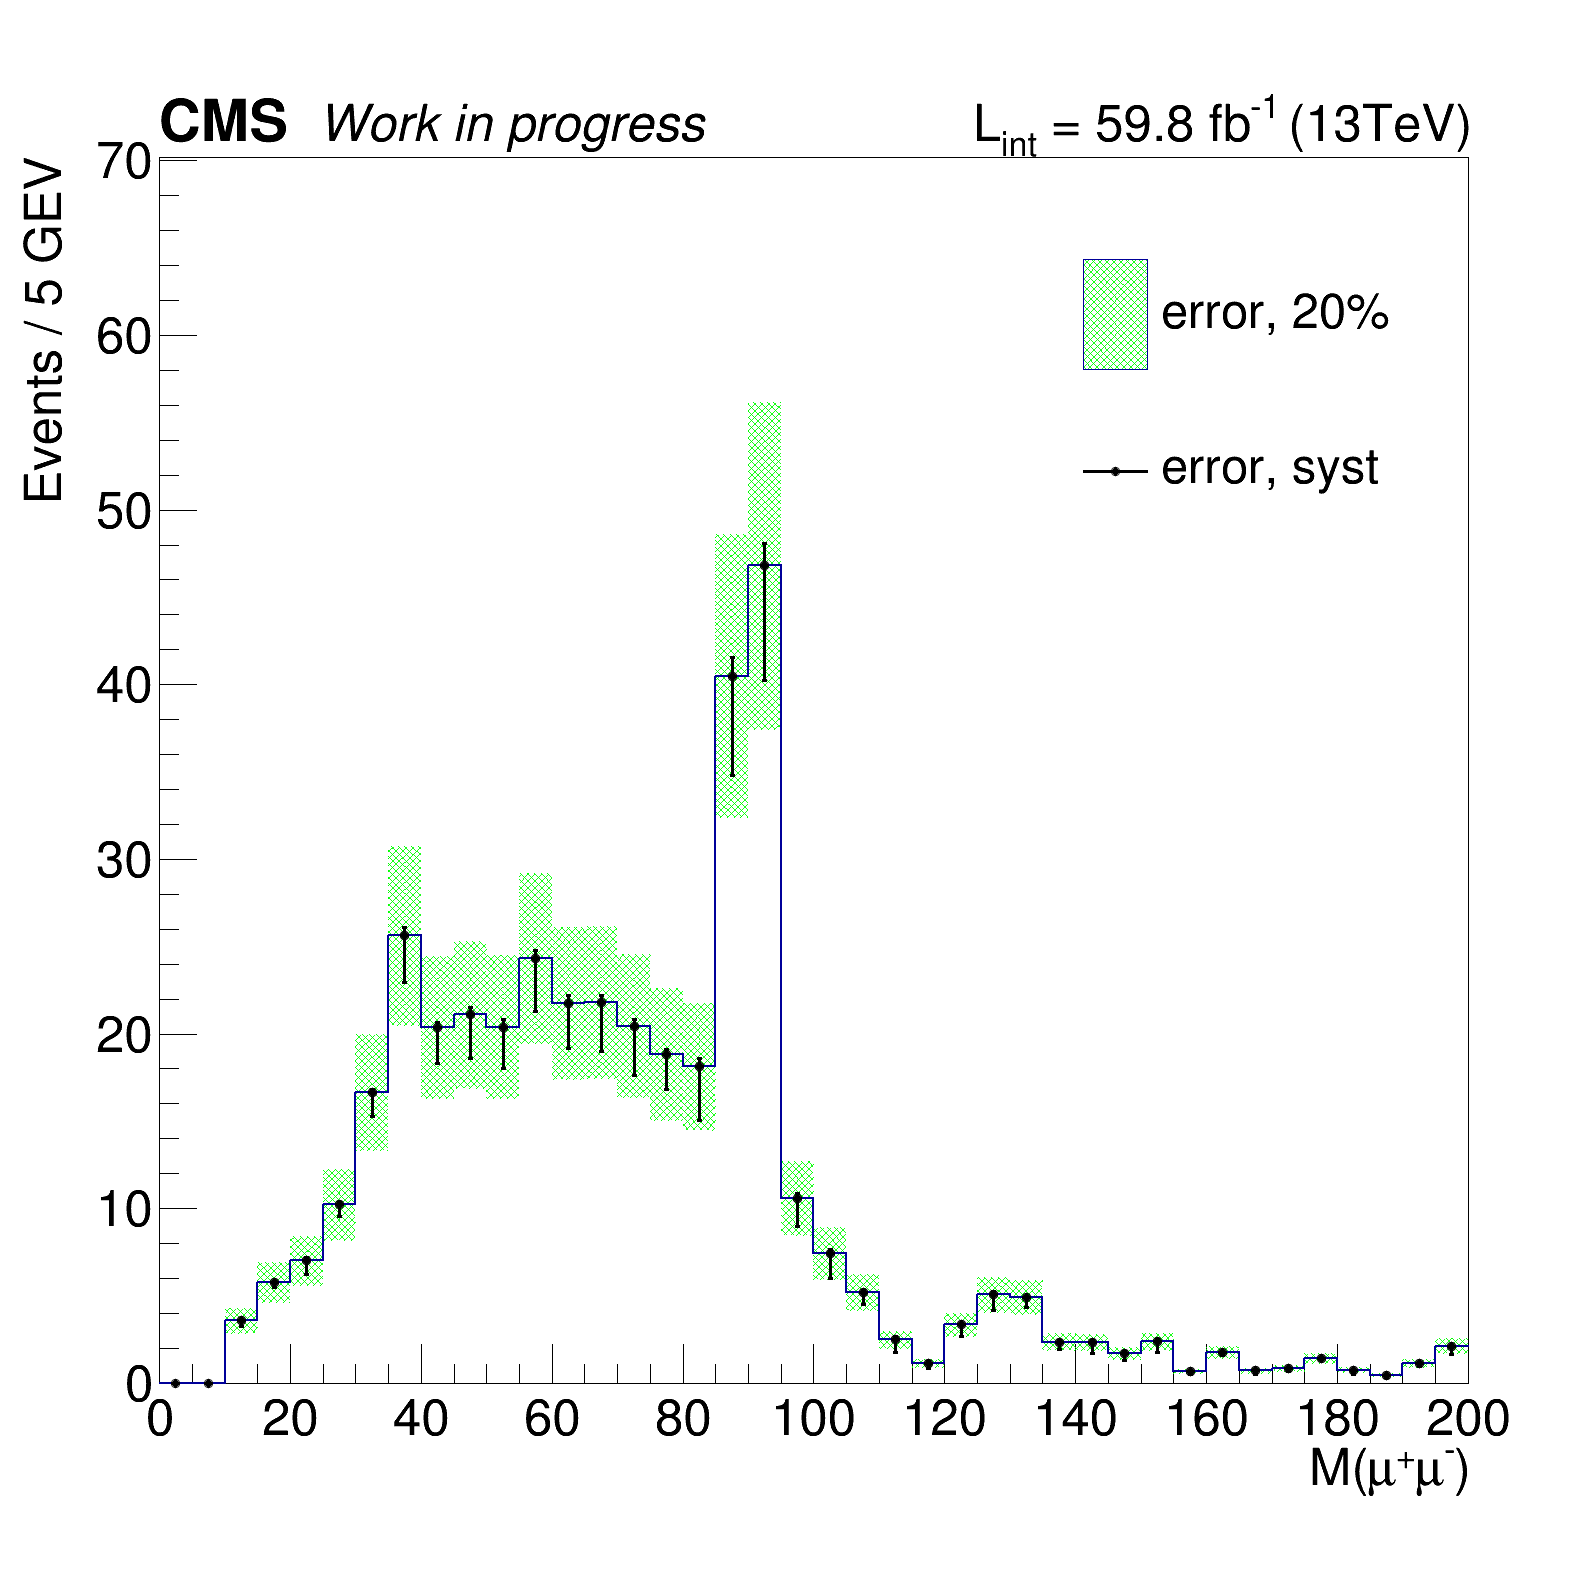

In [21]:
canvas = ROOT.TCanvas("c", "Systematic Errors", 1600, 1600)
canvas.SetLeftMargin(0.1)
canvas.SetRightMargin(0.08)
canvas.SetTopMargin(0.1)
canvas.SetBottomMargin(0.12)

legend = ROOT.TLegend(0.67, 0.65, 0.9, 0.85)
legend.SetFillStyle(0)
legend.SetBorderSize(0)

h_Central.SetLineWidth(2)
h_Central.GetXaxis().SetTitle("M(#mu^{+}#mu^{-})")
h_Central.GetYaxis().SetTitle("Events / 5 GEV")
h_Central.GetYaxis().SetTitleOffset(1.3)
h_Central.GetYaxis().SetRangeUser(0., h_Central.GetMaximum()*1.5)
h_error.SetMarkerStyle(20)
h_error.SetFillColorAlpha(ROOT.kGreen, 0.9)
h_error.SetFillStyle(3144)


g.SetMarkerStyle(20)
g.SetMarkerColor(ROOT.kBlack)
g.SetLineWidth(3)
g.SetLineColor(ROOT.kBlack)

legend.AddEntry(h_error, "error, 20%", "f")
legend.AddEntry(g, "error, syst", "pl")

canvas.cd()
h_Central.Draw("hist")
h_error.Draw("e2 fill same")
h_Central.Draw("hist same")
g.Draw("P same")
legend.Draw("same")

text = ROOT.TLatex()
setInfoTo(text); text.DrawLatexNDC(0.61, 0.91, "L_{int} ="+f" {LumiInfo[ERA]}"+" fb^{-1} (13TeV)")
setLogoTo(text); text.DrawLatexNDC(0.1, 0.91, "CMS")
setWorkInProgressTo(text); text.DrawLatexNDC(0.2, 0.91, "Work in progress")
canvas.Draw()